In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from env import get_db_url
import split_scale
import explore

import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

import graphviz
from graphviz import Graph







import warnings
warnings.filterwarnings("ignore")

# Baseline Model

For the baseline, I'm just using intuition to select columns, more feature engineering will be involved in the actual process

### Wrangle Data

- Pull dataframe from telco_churn database

In [2]:
query = '''
select * from customers;
'''
churn = pd.read_sql(query, get_db_url('telco_churn'))

- Surface level look at data
- **No Nulls**
- **total_charges should be a float**

In [3]:
churn.info()
churn.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customer_id                 7043 non-null object
gender                      7043 non-null object
senior_citizen              7043 non-null int64
partner                     7043 non-null object
dependents                  7043 non-null object
tenure                      7043 non-null int64
phone_service               7043 non-null object
multiple_lines              7043 non-null object
internet_service_type_id    7043 non-null int64
online_security             7043 non-null object
online_backup               7043 non-null object
device_protection           7043 non-null object
tech_support                7043 non-null object
streaming_tv                7043 non-null object
streaming_movies            7043 non-null object
contract_type_id            7043 non-null int64
paperless_billing           7043 non-null object
payment_type_id             7043 non-null int64
monthly_charges 

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service_type_id,online_security,...,device_protection,tech_support,streaming_tv,streaming_movies,contract_type_id,paperless_billing,payment_type_id,monthly_charges,total_charges,churn
0,0002-ORFBO,Female,0,Yes,Yes,9,Yes,No,1,No,...,No,Yes,Yes,No,2,Yes,2,65.6,593.3,No
1,0003-MKNFE,Male,0,No,No,9,Yes,Yes,1,No,...,No,No,No,Yes,1,No,2,59.9,542.4,No
2,0004-TLHLJ,Male,0,No,No,4,Yes,No,2,No,...,Yes,No,No,No,1,Yes,1,73.9,280.85,Yes
3,0011-IGKFF,Male,1,Yes,No,13,Yes,No,2,No,...,Yes,No,Yes,Yes,1,Yes,1,98.0,1237.85,Yes
4,0013-EXCHZ,Female,1,Yes,No,3,Yes,No,2,No,...,No,Yes,Yes,No,1,Yes,2,83.9,267.4,Yes


- find errors in total_charges

In [4]:
churn[['total_charges']].sort_values('total_charges').head(12)

,total_charges
2855,
3118,
3052,
5433,
1731,
4054,
2176,
2250,
945,
1906,


In [5]:
churn.replace(r'^\s*$', np.nan, regex=True, inplace=True)
churn = churn.dropna(axis=0)
churn.total_charges = churn.total_charges.astype(float)

In [6]:
churn.describe()

,senior_citizen,tenure,internet_service_type_id,contract_type_id,payment_type_id,monthly_charges,total_charges
count,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.162400,32.421786,1.872582,1.688567,2.315557,64.798208,2283.300441
std,0.368844,24.545260,0.737271,0.832934,1.149523,30.085974,2266.771362
min,0.000000,1.000000,1.000000,1.000000,1.000000,18.250000,18.800000
25%,0.000000,9.000000,1.000000,1.000000,1.000000,35.587500,401.450000
50%,0.000000,29.000000,2.000000,1.000000,2.000000,70.350000,1397.475000
75%,0.000000,55.000000,2.000000,2.000000,3.000000,89.862500,3794.737500
max,1.000000,72.000000,3.000000,3.000000,4.000000,118.750000,8684.800000


- define features and target

In [7]:
target = 'churn'
features = churn.columns.tolist()
features.remove(target)
features.remove('customer_id')
print(f' target: {target}\nfeatures:{features}')

 target: churn
features:['gender', 'senior_citizen', 'partner', 'dependents', 'tenure', 'phone_service', 'multiple_lines', 'internet_service_type_id', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'contract_type_id', 'paperless_billing', 'payment_type_id', 'monthly_charges', 'total_charges']


- encode object columns

In [8]:

for i in churn.select_dtypes(object).columns.tolist():
    churn[i] = LabelEncoder().fit_transform(churn[i])

- Scale float comumns

In [9]:
train, test = split_scale.split_my_data(churn, stratify=churn.churn)
scaler, train[['monthly_charges', 'total_charges']], test[['monthly_charges', 'total_charges']] = split_scale.standard_scaler(train[['monthly_charges', 'total_charges']], test[['monthly_charges', 'total_charges']])

### Model
- just a quick decision tree

In [10]:
tree = DecisionTreeClassifier(max_depth= 5,random_state=123)

tree.fit(train[features], train[target])
predicted_churn = tree.predict(train[features])
print(classification_report(train[target], predicted_churn))

              precision    recall  f1-score   support

           0       0.84      0.91      0.87      4130
           1       0.67      0.50      0.58      1495

    accuracy                           0.80      5625
   macro avg       0.75      0.71      0.72      5625
weighted avg       0.79      0.80      0.79      5625



In [11]:
feature_importances = {}
for i in range(len(features)):
    feature_importances[features[i]] = list(tree.feature_importances_)[i]
sorted(feature_importances.items(), key = lambda kv: kv[1], reverse = True)

[('contract_type_id', 0.522133231282088),
 ('online_security', 0.13797118458275068),
 ('tenure', 0.09412577929981143),
 ('internet_service_type_id', 0.09148632016127721),
 ('total_charges', 0.08039683457241584),
 ('monthly_charges', 0.04066231151456985),
 ('tech_support', 0.00837735812318337),
 ('online_backup', 0.008169183610034353),
 ('senior_citizen', 0.006356362698273441),
 ('payment_type_id', 0.0040956666432481505),
 ('streaming_movies', 0.003972845836448954),
 ('gender', 0.002252921675898517),
 ('partner', 0.0),
 ('dependents', 0.0),
 ('phone_service', 0.0),
 ('multiple_lines', 0.0),
 ('device_protection', 0.0),
 ('streaming_tv', 0.0),
 ('paperless_billing', 0.0)]

### Baseline Results

- Baseline accuracy of 80%

# Minimum Viable Product

### Questions to address:
- Could the month in which they signed up influence churn?
- Are there features that indicate a higher propensity to churn? 
- Is there a price threshold for specific services where the likelihood of churn increases once price for those services goes past that point?
- If we looked at churn rate for month-to-month customers after the 12th month and that of 1-year contract customers after the 12th month, are those rates comparable?

### Data Aquisition
- get telco_churn data

In [12]:
query = '''
select * 
from customers as cust
join `internet_service_types` as net
on cust.`internet_service_type_id` = net.internet_service_type_id
join `contract_types` as cont
on cust.`contract_type_id` = cont.`contract_type_id`
join payment_types as pmt
using(`payment_type_id`);
'''
churn_df = pd.read_sql(query, get_db_url('telco_churn'))
churn_df.info()
churn_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 26 columns):
payment_type_id             7043 non-null int64
customer_id                 7043 non-null object
gender                      7043 non-null object
senior_citizen              7043 non-null int64
partner                     7043 non-null object
dependents                  7043 non-null object
tenure                      7043 non-null int64
phone_service               7043 non-null object
multiple_lines              7043 non-null object
internet_service_type_id    7043 non-null int64
online_security             7043 non-null object
online_backup               7043 non-null object
device_protection           7043 non-null object
tech_support                7043 non-null object
streaming_tv                7043 non-null object
streaming_movies            7043 non-null object
contract_type_id            7043 non-null int64
paperless_billing           7043 non-null object
monthly_charges 

,payment_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service_type_id,...,contract_type_id,paperless_billing,monthly_charges,total_charges,churn,internet_service_type_id,internet_service_type,contract_type_id,contract_type,payment_type
0,2,0003-MKNFE,Male,0,No,No,9,Yes,Yes,1,...,1,No,59.9,542.4,No,1,DSL,1,Month-to-month,Mailed check
1,4,0013-MHZWF,Female,0,No,Yes,9,Yes,No,1,...,1,Yes,69.4,571.45,No,1,DSL,1,Month-to-month,Credit card (automatic)
2,1,0015-UOCOJ,Female,1,No,No,7,Yes,No,1,...,1,Yes,48.2,340.35,No,1,DSL,1,Month-to-month,Electronic check
3,1,0023-HGHWL,Male,1,No,No,1,No,No phone service,1,...,1,Yes,25.1,25.1,Yes,1,DSL,1,Month-to-month,Electronic check
4,3,0032-PGELS,Female,0,Yes,Yes,1,No,No phone service,1,...,1,No,30.5,30.5,Yes,1,DSL,1,Month-to-month,Bank transfer (automatic)


### Prepare

- drop duplicates

In [13]:
#for duplicate columns
churn_df = churn_df.loc[:,~churn_df.columns.duplicated()]

#for duplicat rows
churn_df = churn_df.drop_duplicates()

- drop redundant columns

In [14]:
churn_df = (churn_df.drop('contract_type_id', axis = 1)
                    .drop('internet_service_type_id', axis = 1)
                    .drop('payment_type_id', axis = 1))

In [15]:
churn_df.columns.tolist()

['customer_id',
 'gender',
 'senior_citizen',
 'partner',
 'dependents',
 'tenure',
 'phone_service',
 'multiple_lines',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'paperless_billing',
 'monthly_charges',
 'total_charges',
 'churn',
 'internet_service_type',
 'contract_type',
 'payment_type']

- remove 'no internet service's

In [16]:
churn_df.replace('No internet service', 'No', inplace=True)
churn_df.replace('No phone service', 'No', inplace=True)

- encode columns with just a few unique values

In [17]:
churn_df['churn'] = LabelEncoder().fit_transform(churn_df['churn']).astype(bool)
churn_df.senior_citizen = churn_df.senior_citizen.astype(bool)
# for i in churn_df.columns.tolist():
#     if churn_df[i].nunique() <= 5:
#         churn_df[i] = LabelEncoder().fit_transform(churn_df[i])

- new boolean column 'e-check'

In [18]:
churn_df['e_check'] = churn_df.payment_type == 'Electronic check'

- fix tenure white spaces

In [19]:
churn_df.replace(r'^\s*$', np.nan, regex=True, inplace=True)
churn_df = churn_df.dropna(axis=0)
churn_df.total_charges = churn_df.total_charges.astype(float)

- set features and target

In [20]:
target = ['churn']
features = churn_df.columns.tolist()
features.remove(target[0])
features.remove('customer_id')
print(f'target: {target}\nfeatures: {features}')

target: ['churn']
features: ['gender', 'senior_citizen', 'partner', 'dependents', 'tenure', 'phone_service', 'multiple_lines', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'paperless_billing', 'monthly_charges', 'total_charges', 'internet_service_type', 'contract_type', 'payment_type', 'e_check']


In [21]:
train, test = split_scale.split_my_data(churn_df, stratify = churn_df.churn)

- get features that need to be scaled

In [22]:
scaler_features = []
for i in features:
    if churn_df[i].nunique() > 5:
        scaler_features.append(i)
scaler_features

['tenure', 'monthly_charges', 'total_charges']

In [23]:
train_scaled, test_scaled = train.copy(), test.copy()
scaler, train_scaled[scaler_features], test_scaled[scaler_features] = split_scale.standard_scaler(train_scaled[scaler_features], test_scaled[scaler_features])
train_scaled[scaler_features].head()

,tenure,monthly_charges,total_charges
4287,1.538163,-0.660095,0.430482
5954,0.555186,-0.821412,-0.198420
3976,1.579121,0.056682,1.060689
2595,1.087632,0.939765,1.369157
6696,1.538163,-1.358579,-0.250860


### Explore

First lets see if we can answer any of the posted questions
- is there a significant time frame that customers are churning
    - Yes, churn drops significantly after the first six months and continues to drop over time

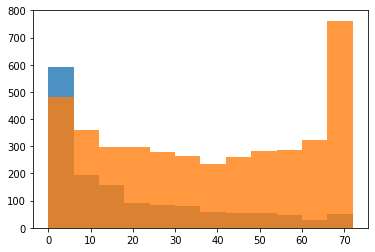

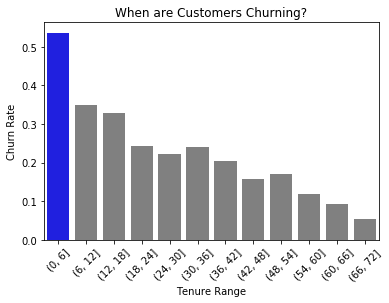

In [24]:
# Is there a tenure that is more likely to churn
bins = [0,6,12,18,24,30,36,42,48,54,60,66,72]
plt.hist('tenure', data = train[train.churn == True], alpha = .8, bins = bins)
plt.hist('tenure', data = train[train.churn == False], alpha = .8, bins = bins)
plt.show()

hist_data = train[['churn']].groupby([pd.cut(train.tenure, bins)]).mean()
clrs = ['grey' if (x < max(hist_data.churn)) else 'blue' for x in hist_data.churn ]
sns.barplot(x = hist_data.index.tolist(), y = hist_data.churn, palette = clrs)
plt.ylabel('Churn Rate')
plt.xlabel('Tenure Range')
plt.xticks(rotation = 45)
plt.title('When are Customers Churning?')
plt.show()


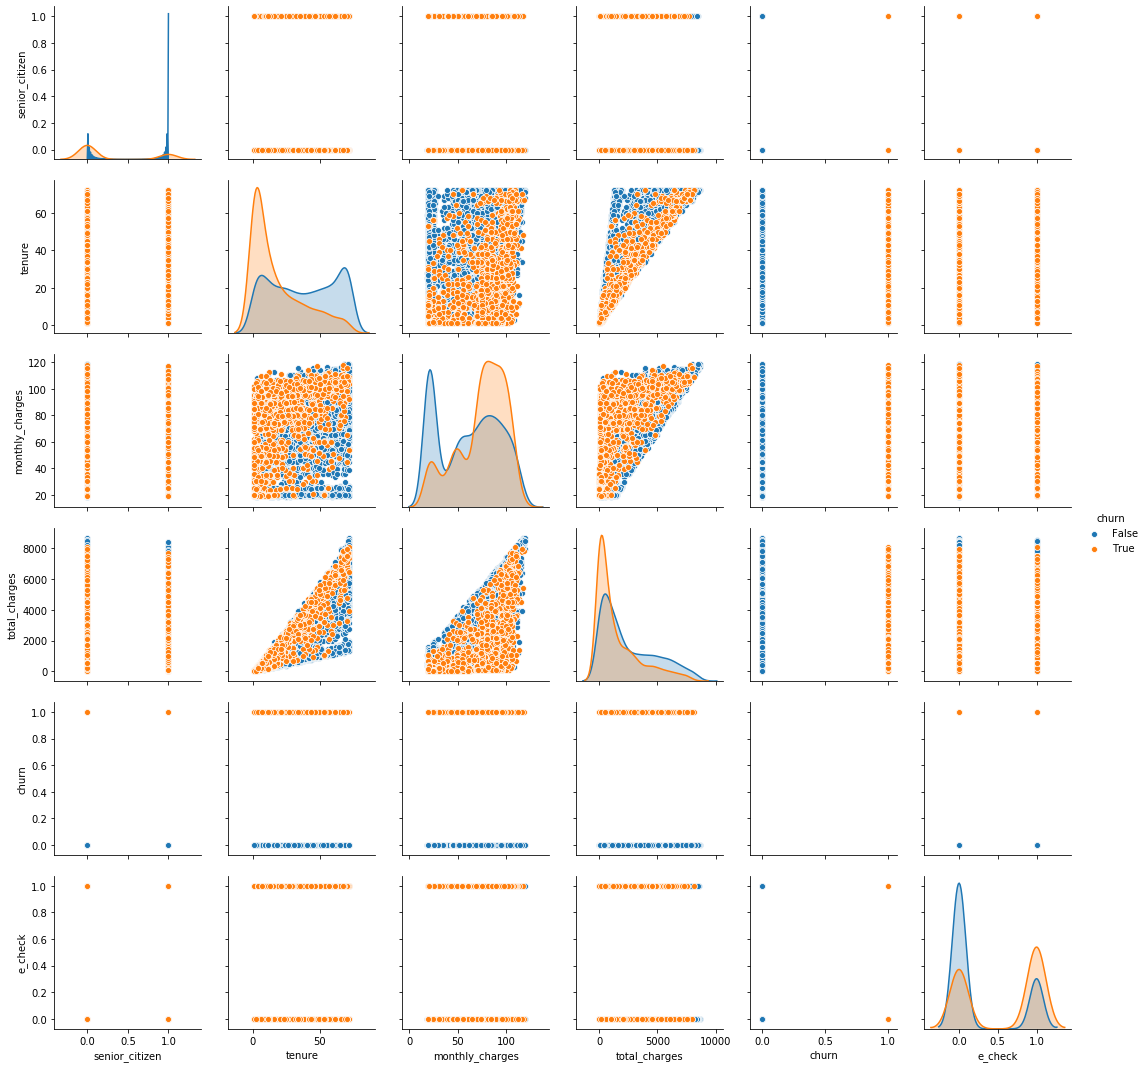

In [25]:
sns.pairplot(train, hue='churn')

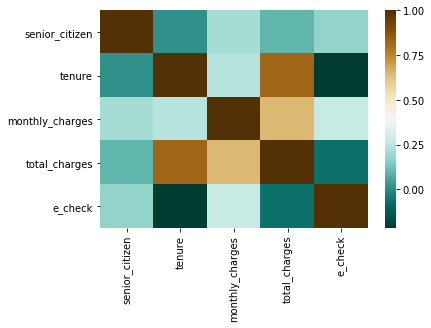

In [26]:
sns.heatmap(train_scaled[features].corr(), cmap = 'BrBG_r')

- total charges is highly correlated with tenure and monthly chargest, so we'll remove it

In [27]:
features.remove('total_charges')

- are there features that indicate a higher liklyhood of churning?
    - yes. **partner, dependants, online_security, online_backup, tech_support, paperless_billing, internet_service_type, contract_type,** and **payment_type**  all have large impacts on churn

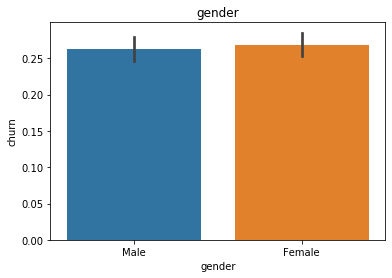

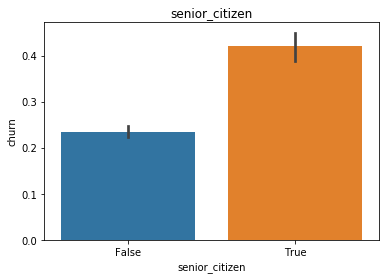

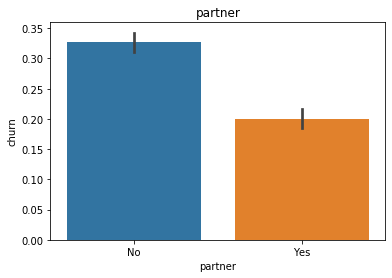

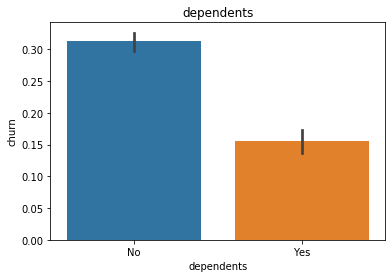

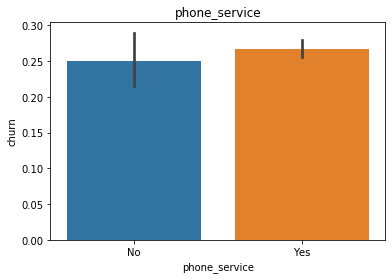

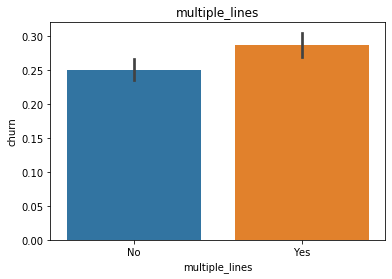

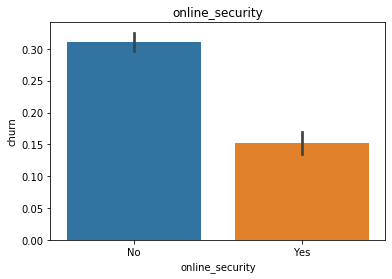

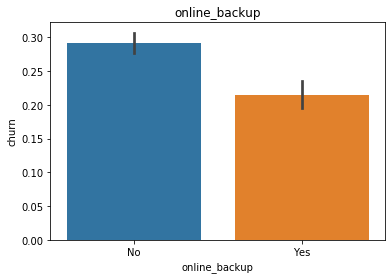

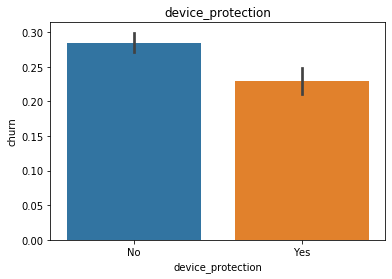

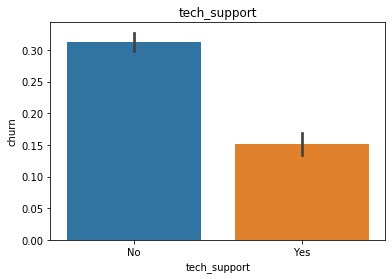

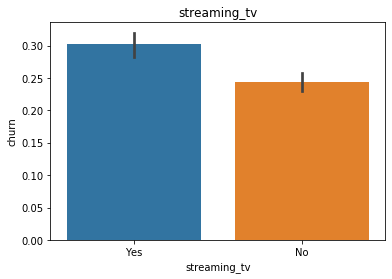

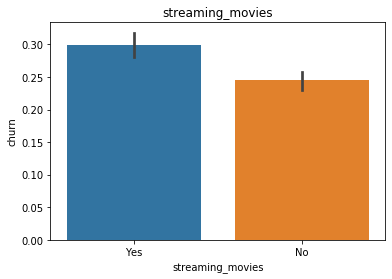

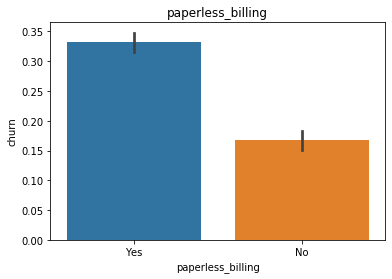

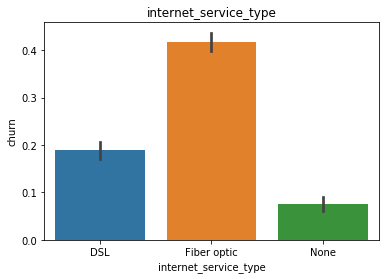

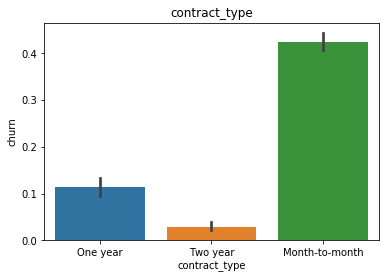

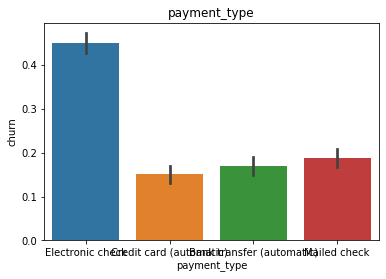

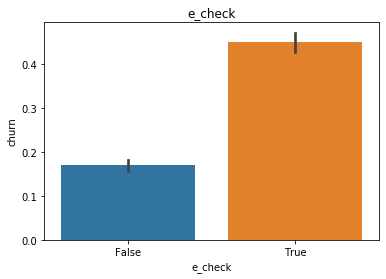

In [28]:
explore.plot_bars(features, target[0], train_scaled)

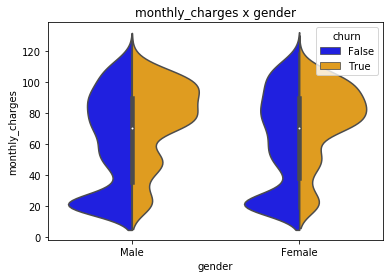

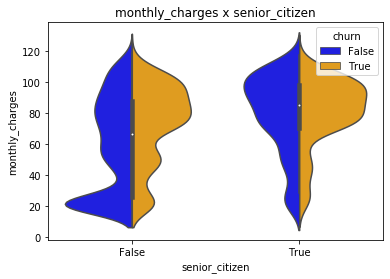

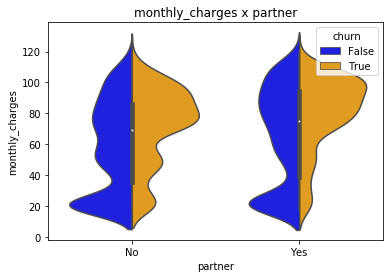

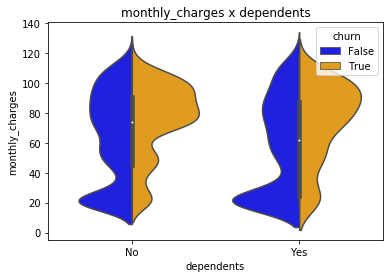

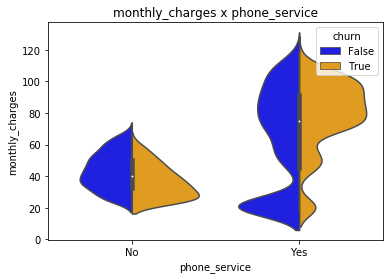

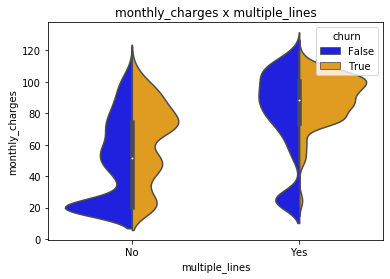

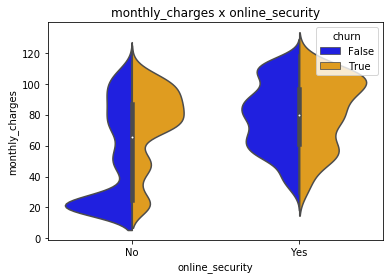

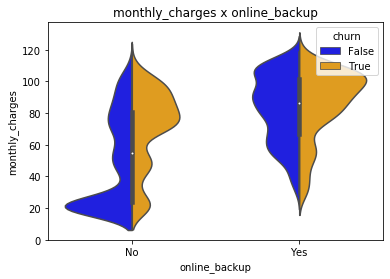

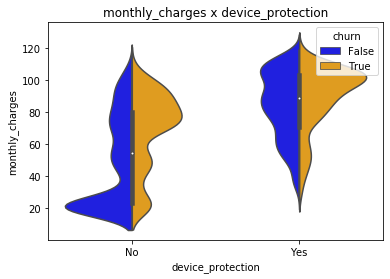

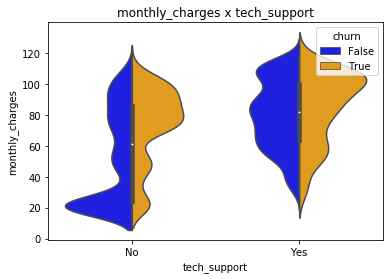

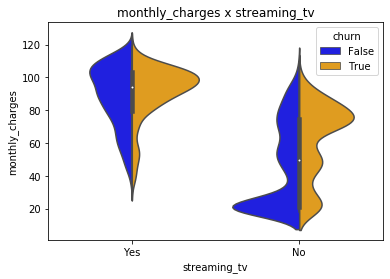

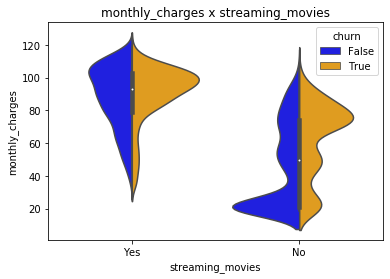

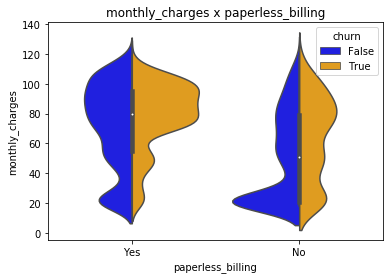

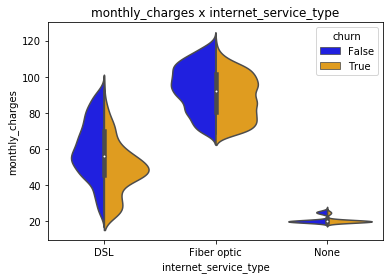

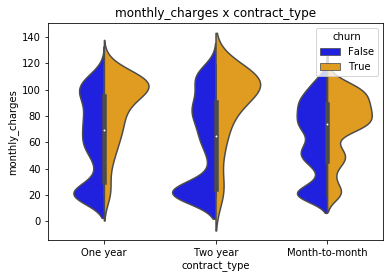

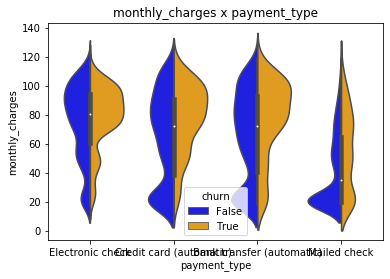

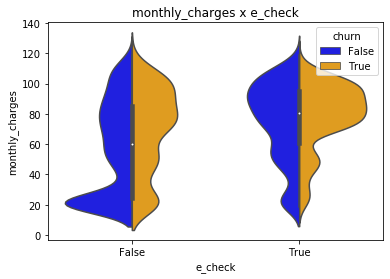

In [29]:
explore.plot_violin(features, target[0], train)

- is there a price threshhold where churn increases?
    - it looks like churn jumps at 30 dollars and again at 70 dollars

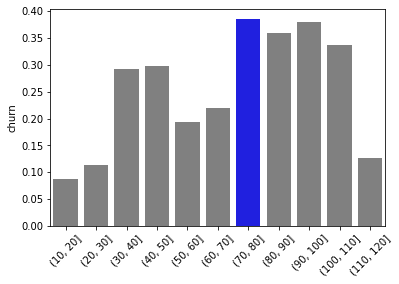

In [30]:
bins = range(10,130,10)
hist_data = train[['churn']].groupby([pd.cut(train.monthly_charges, bins)]).mean()
hist_data
clrs = ['grey' if (x < max(hist_data.churn)) else 'blue' for x in hist_data.churn ]
sns.barplot(x = hist_data.index.tolist(), y = hist_data.churn, palette = clrs)
plt.xticks(rotation = 45)
plt.show()

- are churn rates comparable for m-m, one yr, and two yr?
    - no

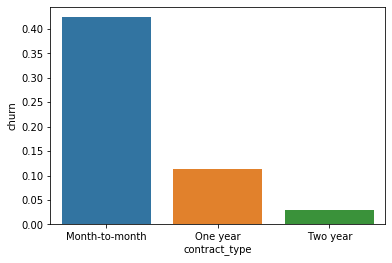

In [31]:
bars = train.groupby('contract_type').churn.mean()
sns.barplot(x = bars.index, y = bars)

- controlling for services, is mean monthly charges significantly different?
    - yes

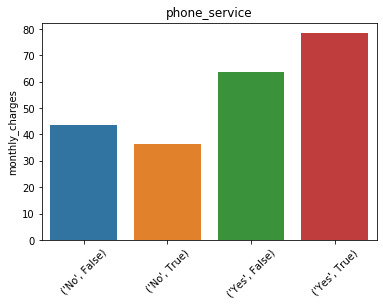

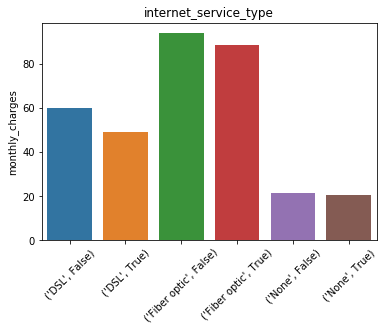

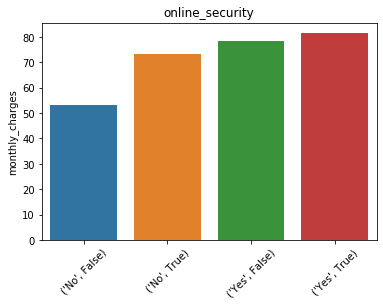

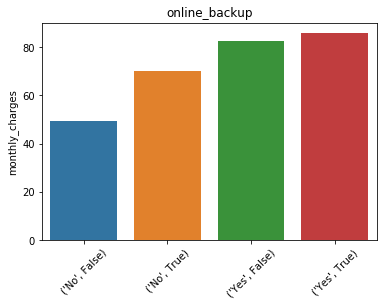

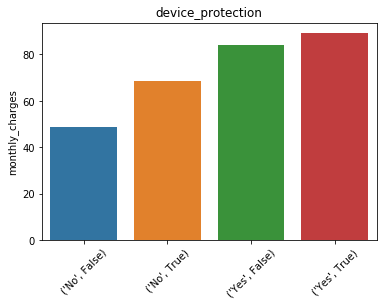

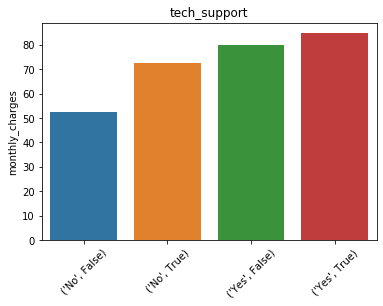

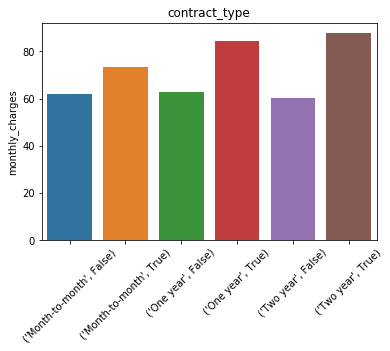

In [32]:
services = ['phone_service', 'internet_service_type', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'contract_type']
for i in services:
    bars = train.groupby([i, 'churn']).monthly_charges.mean()
    sns.barplot(x = bars.index, y = bars)
    plt.title(i)
    plt.xticks(rotation = 45)
    plt.show()
    

**Takeaways**

- total_charges can be dropped, it correlates too much with monthly_charges and tenure
- phone service does not appear to have significant impact on tenure
- gender does not appear to have significant impact on tenure
- electronic check has significantly higher instance of churn than other payment methods
- online security, and techsupport appear to be strongly correlated
- online backup and device protection appear to be strongly correlated
- streaming tv and streaming movies appear to be strongly correlated

**last data clean**

In [33]:
features.remove('gender')
features.remove('phone_service')
features.remove('payment_type')
features.remove('contract_type')
features.remove('internet_service_type')
features.remove('multiple_lines')

- Before moving into modeling, we'll need to encode all categorical collumns

In [34]:
#change yes-no collumns to boolean values (yes = True, no = False)
for i in features:
    if train[i].unique().tolist() == ['No', 'Yes'] or train[i].unique().tolist() == ['Yes', 'No']:
        train[i] = train[i] == 'Yes'
        test[i] = test[i] == 'Yes'

- one hot encode rows with three or more variables


In [35]:
train = (train.join(pd.get_dummies(train.contract_type), on= train.index)
              .join(pd.get_dummies(train.internet_service_type), on = train.index))
test = (test.join(pd.get_dummies(test.contract_type), on= test.index)
           .join(pd.get_dummies(test.internet_service_type), on = test.index))
train.head()



,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,...,internet_service_type,contract_type,payment_type,e_check,Month-to-month,One year,Two year,DSL,Fiber optic,None
4287,7136-RVDTZ,Male,True,False,False,70,No,No,False,False,...,DSL,One year,Electronic check,True,0,1,0,1,0,0
5954,9674-EHPPG,Male,False,True,False,46,No,No,True,False,...,DSL,Two year,Credit card (automatic),False,0,0,1,1,0,0
3976,1866-DIOQZ,Female,False,True,False,71,No,No,True,True,...,DSL,One year,Bank transfer (automatic),False,0,1,0,1,0,0
2595,6300-BWMJX,Female,False,True,False,59,Yes,Yes,False,False,...,Fiber optic,Month-to-month,Electronic check,True,1,0,0,0,1,0
6696,4589-IUAJB,Male,False,True,False,70,Yes,Yes,False,False,...,None,Two year,Bank transfer (automatic),False,0,0,1,0,0,1


- add new collumns to features list

In [36]:
new_features = pd.get_dummies(train.contract_type).columns.tolist()
new_features += pd.get_dummies(train.internet_service_type).columns.tolist()
features += new_features
train[features].head()

,senior_citizen,partner,dependents,tenure,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,e_check,Month-to-month,One year,Two year,DSL,Fiber optic,None
4287,True,False,False,70,False,False,False,False,True,True,True,45.25,True,0,1,0,1,0,0
5954,False,True,False,46,True,False,True,True,False,False,False,40.40,False,0,0,1,1,0,0
3976,False,True,False,71,True,True,True,True,True,True,False,66.80,False,0,1,0,1,0,0
2595,False,True,False,59,False,False,True,True,True,False,False,93.35,True,1,0,0,0,1,0
6696,False,True,False,70,False,False,False,False,False,False,False,24.25,False,0,0,1,0,0,1


### Modeling

Logistic Regression

In [37]:
logit = LogisticRegression()
logit.fit(train[features], train[target])
predicted = logit.predict(train[features])
print(classification_report(train[target], predicted))
confusion_matrix(train[target], predicted)

              precision    recall  f1-score   support

       False       0.84      0.90      0.87      4130
        True       0.66      0.54      0.59      1495

    accuracy                           0.80      5625
   macro avg       0.75      0.72      0.73      5625
weighted avg       0.79      0.80      0.80      5625



array([[3712,  418],
       [ 692,  803]])

In [38]:
feature_importances = {}
for i in range(len(features)):
    feature_importances[features[i]] = list(logit.coef_.tolist()[0])[i]
sorted(feature_importances.items(), key = lambda kv: kv[1], reverse = True)

[('Fiber optic', 0.9268509599411486),
 ('Month-to-month', 0.4836254615521555),
 ('streaming_tv', 0.40469025521356333),
 ('e_check', 0.33995413530022267),
 ('streaming_movies', 0.3287634932138341),
 ('paperless_billing', 0.3131995702801035),
 ('senior_citizen', 0.28759836238207065),
 ('device_protection', 0.09330374349500509),
 ('partner', 0.06295883407895478),
 ('monthly_charges', -0.008974962036098056),
 ('tenure', -0.032576904556758754),
 ('online_backup', -0.07957442260467999),
 ('One year', -0.18870534118282065),
 ('DSL', -0.19227791422330043),
 ('dependents', -0.2034467488557292),
 ('online_security', -0.26469774386574924),
 ('tech_support', -0.3284710764963009),
 ('Two year', -0.8127962861753354),
 ('None', -1.2524492115238928)]

Decision Tree

In [39]:
tree = DecisionTreeClassifier(max_depth= 5,random_state=123)

tree.fit(train[features], train[target])
predicted = tree.predict(train[features])
print(classification_report(train[target], predicted))
confusion_matrix(train[target], predicted)

              precision    recall  f1-score   support

       False       0.85      0.88      0.87      4130
        True       0.63      0.57      0.60      1495

    accuracy                           0.80      5625
   macro avg       0.74      0.72      0.73      5625
weighted avg       0.79      0.80      0.79      5625



array([[3643,  487],
       [ 648,  847]])

In [40]:
predicted = tree.predict(test[features])
print(classification_report(test[target], predicted))
confusion_matrix(test[target], predicted)

              precision    recall  f1-score   support

       False       0.84      0.89      0.87      1033
        True       0.65      0.55      0.59       374

    accuracy                           0.80      1407
   macro avg       0.75      0.72      0.73      1407
weighted avg       0.79      0.80      0.79      1407



array([[922, 111],
       [170, 204]])

                    0         1
0      Month-to-month  0.507643
1              tenure  0.212785
2         Fiber optic  0.155682
3     monthly_charges  0.055366
4                None  0.024121
5            Two year  0.013691
6      senior_citizen  0.011904
7        tech_support  0.006536
8        streaming_tv  0.004445
9    streaming_movies  0.003379
10    online_security  0.002602
11            e_check  0.001844
12            partner  0.000000
13         dependents  0.000000
14      online_backup  0.000000
15  device_protection  0.000000
16  paperless_billing  0.000000
17           One year  0.000000
18                DSL  0.000000


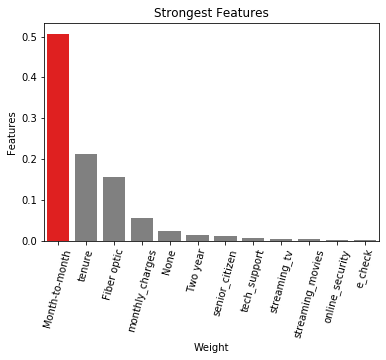

<Figure size 432x288 with 0 Axes>

In [41]:
feature_importances = {}
for i in range(len(features)):
    feature_importances[features[i]] = list(tree.feature_importances_)[i]

coefs = pd.DataFrame(sorted(feature_importances.items(), key = lambda kv: kv[1], reverse = True))
print(coefs)

clrs = ['grey' if (x < max(coefs[1])) else 'red' for x in coefs[1] ]
sns.barplot(x = 0, y = 1, data = coefs[coefs[1] > 0], palette = clrs)
plt.ylabel('Features', )
plt.xlabel('Weight')
plt.xticks(rotation = 75)
plt.title('Strongest Features')
plt.style.use("dark_background")
plt.show()
plt.savefig('strongest_festures')

In [ ]:
prediction_deliverable = churn_df[['customer_id']]
df = train.append(test)
probabilities = pd.DataFrame(tree.predict_proba(df[features]), columns= ['p_nochurn', 'p_churn'], index = df.index)

prediction_deliverable = prediction_deliverable.join(probabilities, on = prediction_deliverable.index)

predictions = pd.DataFrame(tree.predict(df[features]), index = df.index, columns= ['will_churn'])

prediction_deliverable = prediction_deliverable.join(predictions, on = prediction_deliverable.index)
prediction_deliverable.dropna(inplace = True)
prediction_deliverable.to_csv('prediction_csv')

In [42]:
tree_graph = export_graphviz(tree)
graph = graphviz.Source(tree_graph)

graph.render('telco_churn_decision_tree', view = True)

'telco_churn_decision_tree.pdf'

Random forrest

In [43]:
forrest = RandomForestClassifier(min_samples_leaf = 30, max_depth = 50, random_state=123)
forrest.fit(train[features], train[target])
predicted = forrest.predict(train[features])
print(classification_report(train[target], predicted))
confusion_matrix(train[target], predicted)

              precision    recall  f1-score   support

       False       0.83      0.92      0.88      4130
        True       0.70      0.49      0.57      1495

    accuracy                           0.81      5625
   macro avg       0.76      0.71      0.72      5625
weighted avg       0.80      0.81      0.80      5625



array([[3810,  320],
       [ 764,  731]])

In [44]:
predicted = forrest.predict(test[features])
print(classification_report(test[target], predicted))
confusion_matrix(test[target], predicted)

              precision    recall  f1-score   support

       False       0.83      0.93      0.88      1033
        True       0.71      0.49      0.58       374

    accuracy                           0.81      1407
   macro avg       0.77      0.71      0.73      1407
weighted avg       0.80      0.81      0.80      1407



array([[958,  75],
       [190, 184]])

In [45]:
feature_importances = {}
for i in range(len(features)):
    feature_importances[features[i]] = list(forrest.feature_importances_)[i]
sorted(feature_importances.items(), key = lambda kv: kv[1], reverse = True)

[('tenure', 0.25225951507345395),
 ('Month-to-month', 0.19180136818702564),
 ('Fiber optic', 0.10364126711960257),
 ('Two year', 0.07838326583797907),
 ('monthly_charges', 0.07814783133018871),
 ('None', 0.06264760469845121),
 ('e_check', 0.046776264806734184),
 ('DSL', 0.04524803420458866),
 ('One year', 0.03791846533532147),
 ('tech_support', 0.028336614183981177),
 ('online_backup', 0.013995651545353711),
 ('online_security', 0.01380342004242293),
 ('streaming_tv', 0.010695103820456598),
 ('senior_citizen', 0.010393957627602176),
 ('paperless_billing', 0.009199663527199363),
 ('partner', 0.007432871304612281),
 ('streaming_movies', 0.004400658211565725),
 ('device_protection', 0.0034712445070256732),
 ('dependents', 0.0014471986364347643)]

### Refine model:

- scaling down data to only include customers who have been with us for > 6 months

In [46]:
train = train[train.tenure > 6]
test = test[test.tenure > 6]
features.remove('senior_citizen')

In [47]:
tree = DecisionTreeClassifier(max_depth= 5,random_state=123)

tree.fit(train[features], train[target])
predicted = tree.predict(train[features])
print(classification_report(train[target], predicted))
confusion_matrix(train[target], predicted)

              precision    recall  f1-score   support

       False       0.86      0.94      0.90      3593
        True       0.61      0.38      0.47       873

    accuracy                           0.83      4466
   macro avg       0.74      0.66      0.68      4466
weighted avg       0.81      0.83      0.82      4466



array([[3380,  213],
       [ 542,  331]])

In [48]:
predicted = tree.predict(test[features])
print(classification_report(test[target], predicted))
confusion_matrix(test[target], predicted)

              precision    recall  f1-score   support

       False       0.85      0.94      0.90       884
        True       0.57      0.33      0.42       212

    accuracy                           0.82      1096
   macro avg       0.71      0.64      0.66      1096
weighted avg       0.80      0.82      0.80      1096



array([[831,  53],
       [141,  71]])

- After Evaluation of the refined model, I am unwilling to sacrifice recall of churning customers in exchange for 2% better accuracy, there for I am going to use my origional tree for my model.


## Produce Prediction CSV

In [49]:

prediction_deliverable = churn_df[['customer_id']]
df = train.append(test)
probabilities = pd.DataFrame(tree.predict_proba(df[features]), columns= ['p_nochurn', 'p_churn'], index = df.index)

prediction_deliverable = prediction_deliverable.join(probabilities, on = prediction_deliverable.index)

predictions = pd.DataFrame(tree.predict(df[features]), index = df.index, columns= ['will_churn'])

prediction_deliverable = prediction_deliverable.join(predictions, on = prediction_deliverable.index)
prediction_deliverable.dropna(inplace = True)
prediction_deliverable.to_csv('prediction_csv')